In [1]:
#imports
import csv
import re
import os
import pandas as pd
import numpy as np
import nltk

#for tweet tokenization
from nltk import TweetTokenizer
tt = TweetTokenizer()

from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
pstem = PorterStemmer()
lem = WordNetLemmatizer()


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

from pprint import pprint
from datetime import datetime

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline


#word count
from collections import Counter


#sentiment analysis
from textblob import TextBlob

# spacy for lemmatization
import spacy;
import en_core_web_sm

# Topic modeling
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#escaping html characters
from html.parser import HTMLParser
html_parser = HTMLParser()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/sherinnaha/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
esg = pd.read_csv('../CSV/esg_tweets.csv',sep=';')
esg.head()

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,ReadUseful_Site,Read Useful,898950281148289026,1217234712189685774,/ReadUseful_Site/status/1217234712189685774,2020-01-14 23:59:05,1579046345,New post: Cramer on BlackRock’s climate change...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://lateststories.readuseful.com/cramer-...,...,False,[],NaN,0,0,0,False,False,NaN,[]
1,SulcataStocks,Sulcata Stocks,1211673903531118592,1217227095442624519,/SulcataStocks/status/1217227095442624519,2020-01-14 23:28:49,1579044529,ESG investing is easy to do when everything go...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,True,1.217204e+18,"[{'screen_name': 'CGrantWSJ', 'user_id': '3043..."
2,JCoumarianos,John Coumarianos,499771067,1217215039301656576,/JCoumarianos/status/1217215039301656576,2020-01-14 22:40:54,1579041654,So is ESG investing just all about the E?\n\nB...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.wsj.com/articles/blackrock-shake...,...,False,[],NaN,2,0,0,False,False,NaN,[]
3,brilherman,Herman Bril,2846987907,1217212522937360384,/brilherman/status/1217212522937360384,2020-01-14 22:30:54,1579041054,A big step forward for mainstreaming Sustainab...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://twitter.com/blackrock/status/1217012...,...,False,[],NaN,3,1,0,False,False,NaN,[]
4,MaxH66700380,"Free Assange, now!! ALL lives matter!!",1106699579536351232,1217206397676523520,/MaxH66700380/status/1217206397676523520,2020-01-14 22:06:34,1579039594,"In many cases, yes. But I've also seen genuine...","<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,True,1.217204e+18,"[{'screen_name': 'CGrantWSJ', 'user_id': '3043..."


In [3]:
#dropping duplicates
esg = esg.drop_duplicates(subset = 'text', keep = 'first').reset_index(drop = True)
esg.shape

(13094, 21)

In [4]:
((50629 - 45488)/50629)*100
#~10% tweets are duplicated

10.154259416539928

# Data Cleaning
This does not include Stemming, Lemmatization, Tokenization or Stop Words Removal

In [5]:
#convert to lower case
esg['text'] = esg['text'].str.lower()
esg.head()['text']

0    new post: cramer on blackrock’s climate change...
1    esg investing is easy to do when everything go...
2    so is esg investing just all about the e?\n\nb...
3    a big step forward for mainstreaming sustainab...
4    in many cases, yes. but i've also seen genuine...
Name: text, dtype: object

In [6]:
#Allocating a separate Dataframe for the tweet text
tweets = esg[["text"]]
tweets['original_tweet']= tweets['text']
tweets.shape

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(13094, 2)

In [7]:
# get rid of all kinds of strange symbols from text
def preprocess(Text):
    #Text = Text.str.decode('utf-8')
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\u2066)', ' ')
    Text = Text.str.replace('(\u2069)', ' ')
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    
    #removing twitter images URL
    Text = Text.str.replace('pic.twitter.com', '')
    return Text

#apply all the preprocess functions
tweets['text'] = preprocess(tweets.text)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Removing urls
tweets = tweets.replace('https?:\/\/.*[\r\n]*', '', regex = True)


#removing hashtags(including the word after #), numbers and twitter handles
#removing random symbols after /
tweets = tweets.replace("[0-9]+", '', regex = True)
tweets = tweets.replace("#[a-zA-Z0-9]+", '', regex = True)
tweets = tweets.replace("@[a-zA-Z0-9]+", '', regex = True)
tweets = tweets.replace("/[a-zA-Z0-9]+", '', regex = True)
tweets['text'][0]

'new post: cramer on blackrock’s climate change investing shift, esg and t      '

In [9]:
tweets = tweets.replace("[,@!&\;|'-?\.$%_]",'', regex = True)
tweets['text'][0]

'new post cramer on blackrock’s climate change investing shift esg and t      '

In [10]:
tweets = tweets.replace("[\\u2018\\u2019]", "'", regex = True)

In [11]:
# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
tweets.text = tweets.text.apply(lambda x: rm_punc.sub(' ', x))
tweets.text = tweets.text.apply(lambda x: rm_space.sub(' ', x))
tweets['text'][0]

'new post cramer on blackrock s climate change investing shift esg and t '

In [12]:
#Escaping HTML Characters
tweets.text.apply(lambda x: html_parser.unescape(x))

#Setting to ASCII encoding
tweets.text.apply(lambda x: x.encode('ascii','ignore'))
tweets.text=tweets.text.astype(str)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  


In [13]:
tweets['text'][10]

'the bushfires in australia highlight the growing global climate crisis around the world investments in focused funds such as sustainable responsible and impact investing assets are growing rapidly '

In [14]:
#dealing with contracted words
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
  def expand_match(contraction):
    match = contraction.group(0)
    first_char = match[0]
    expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
    expanded_contraction = first_char+expanded_contraction[1:]
    return expanded_contraction
        
  expanded_text = contractions_pattern.sub(expand_match, text)
  expanded_text = re.sub("'", "", expanded_text)
  return expanded_text


In [15]:
def normalize_corpus(corpus):
  normalized_corpus = []
  
  for doc in corpus:
    doc = expand_contractions(doc)
    normalized_corpus.append(doc)

  return normalized_corpus

tweets['cleaned'] = pd.Series(normalize_corpus(tweets['text']))

In [16]:
#Extracting date and time
#extracting date and time
tweets['timestamp']= esg['timestamp']
tweets['date'] = pd.to_datetime(tweets['timestamp'], errors='coerce').dt.strftime('%Y-%m-%d')
tweets['time'] = pd.to_datetime(tweets['timestamp'], errors='coerce').dt.strftime("%H-%M-%S")

tweets.head()

,text,original_tweet,cleaned,timestamp,date,time
0,new post cramer on blackrock s climate change ...,new post cramer on blackrock's climate change ...,new post cramer on blackrock s climate change ...,2020-01-14 23:59:05,2020-01-14,23-59-05
1,esg investing is easy to do when everything go...,esg investing is easy to do when everything go...,esg investing is easy to do when everything go...,2020-01-14 23:28:49,2020-01-14,23-28-49
2,so is esg investing just all about the e black...,so is esg investing just all about the e\n\nbl...,so is esg investing just all about the e black...,2020-01-14 22:40:54,2020-01-14,22-40-54
3,a big step forward for mainstreaming sustainab...,a big step forward for mainstreaming sustainab...,a big step forward for mainstreaming sustainab...,2020-01-14 22:30:54,2020-01-14,22-30-54
4,in many cases yes but ive also seen genuine es...,in many cases yes but ive also seen genuine es...,in many cases yes but ive also seen genuine es...,2020-01-14 22:06:34,2020-01-14,22-06-34


In [17]:
tweets_copy1 = tweets.copy()

In [18]:
#remove stop words
stop_words = stopwords.words('english')
stop_words[0:5]

['i', 'me', 'my', 'myself', 'we']

In [19]:
not_stopwords = ['not']
common_words =['please',
               'the','would','could','can','may','must', 'should'
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca', 'wealth', 'management']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
tweets_copy1.cleaned = tweets_copy1.cleaned.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))
    
tweets_copy1['cleaned'].head(20)

0     new post cramer blackrock climate change inves...
1     esg investing easy everything goes upsecurity ...
2     esg investing blackrock said increasingly disp...
3     big step forward mainstreaming sustainable inv...
4     many cases yes ive also seen genuine esg inves...
5     one small step one giant leap worlds biggest a...
6                     sustainability stardard investing
7                                    bs bully investing
8     responsible investing takes account environmen...
9                             lays focus sustainability
10    bushfires australia highlight growing global c...
11    fink correct edge fundamental reshaping financ...
12    streamline valuealigned investment research jo...
13                                        investing fad
14    blackrock world largest asset manager shifted ...
15    min read first article discuss global tokenisi...
16    world largest asset manager joins trillion cli...
17    wall street compet advantages huge lucrati

In [20]:
# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
tweets_copy1.text = tweets_copy1.text.apply(lambda x: rm_punc.sub(' ', x))
tweets_copy1.text = tweets_copy1.text.apply(lambda x: rm_space.sub(' ', x))
tweets_copy1['cleaned'].head(20)

0     new post cramer blackrock climate change inves...
1     esg investing easy everything goes upsecurity ...
2     esg investing blackrock said increasingly disp...
3     big step forward mainstreaming sustainable inv...
4     many cases yes ive also seen genuine esg inves...
5     one small step one giant leap worlds biggest a...
6                     sustainability stardard investing
7                                    bs bully investing
8     responsible investing takes account environmen...
9                             lays focus sustainability
10    bushfires australia highlight growing global c...
11    fink correct edge fundamental reshaping financ...
12    streamline valuealigned investment research jo...
13                                        investing fad
14    blackrock world largest asset manager shifted ...
15    min read first article discuss global tokenisi...
16    world largest asset manager joins trillion cli...
17    wall street compet advantages huge lucrati

In [21]:
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
tweets_copy1.cleaned = tweets_copy1.cleaned.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))
    
tweets_copy1['cleaned'].head()

0    new post cramer blackrock climate change inves...
1    esg investing easy everything goes upsecurity ...
2    esg investing blackrock said increasingly disp...
3    big step forward mainstreaming sustainable inv...
4    many cases yes ive also seen genuine esg inves...
Name: cleaned, dtype: object

In [22]:
#new column with a stopwords less column
tweets['sw_clean'] = tweets_copy1['cleaned']
tweets.head()

,text,original_tweet,cleaned,timestamp,date,time,sw_clean
0,new post cramer on blackrock s climate change ...,new post cramer on blackrock's climate change ...,new post cramer on blackrock s climate change ...,2020-01-14 23:59:05,2020-01-14,23-59-05,new post cramer blackrock climate change inves...
1,esg investing is easy to do when everything go...,esg investing is easy to do when everything go...,esg investing is easy to do when everything go...,2020-01-14 23:28:49,2020-01-14,23-28-49,esg investing easy everything goes upsecurity ...
2,so is esg investing just all about the e black...,so is esg investing just all about the e\n\nbl...,so is esg investing just all about the e black...,2020-01-14 22:40:54,2020-01-14,22-40-54,esg investing blackrock said increasingly disp...
3,a big step forward for mainstreaming sustainab...,a big step forward for mainstreaming sustainab...,a big step forward for mainstreaming sustainab...,2020-01-14 22:30:54,2020-01-14,22-30-54,big step forward mainstreaming sustainable inv...
4,in many cases yes but ive also seen genuine es...,in many cases yes but ive also seen genuine es...,in many cases yes but ive also seen genuine es...,2020-01-14 22:06:34,2020-01-14,22-06-34,many cases yes ive also seen genuine esg inves...


# Lemmatization

In [23]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



tweets['text_lemmatized_tokens'] = tweets.sw_clean.apply(lemmatize_text)

In [24]:
tweets_copy3=tweets.copy()

corpus = []
new = tweets_copy3['text_lemmatized_tokens'].values.tolist()
corpus = [word for i in new for word in i]

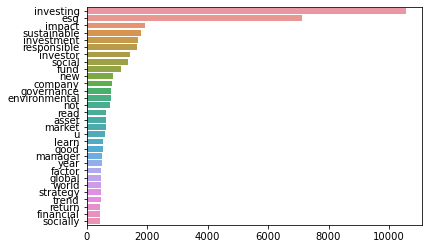

In [25]:
counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
j, k= [], []

for word,count in most[:30]:
    if (word not in final_stop_words):
            x.append(word)
            y.append(count)
        
for word,count in most[:]:
    if (word not in final_stop_words):
        j.append(word)
        k.append(count)
        
sns.barplot(x = y, y = x)

In [26]:
combined_frequency = list(zip(j,k))
with open('blank.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['word','frequency'])
    csv_out.writerows(combined_frequency)

# Bigrams

In [27]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:100]

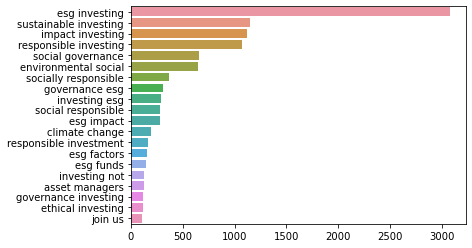

In [28]:
top_n_bigrams=get_top_ngram(tweets['sw_clean'],2)[:20]
all_n_bigrams=get_top_ngram(tweets['sw_clean'],2)
x,y=map(list,zip(*top_n_bigrams))
j,k=map(list,zip(*all_n_bigrams))
sns.barplot(x=y,y=x)

In [29]:
phrase_freq = list(zip(j,k))

with open('bi-gram.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['phrase','frequency'])
    csv_out.writerows(phrase_freq)

# Trigram

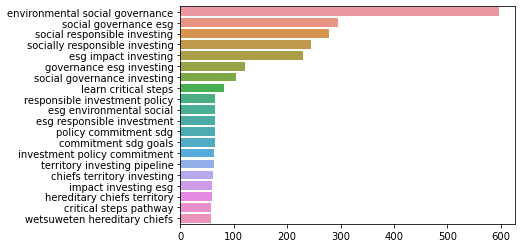

In [30]:
top_n_trigrams=get_top_ngram(tweets['sw_clean'],3)[:20]
all_n_trigrams=get_top_ngram(tweets['sw_clean'],3)
x,y=map(list,zip(*top_n_trigrams))
j,k=map(list,zip(*all_n_trigrams))
sns.barplot(x=y,y=x)

In [33]:
phrase_freq = list(zip(j,k))

with open('tri-gram.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['phrase','frequency'])
    csv_out.writerows(phrase_freq)

In [31]:
keywords=['wetsuweten','territory','heriditary']

In [32]:
df2=tweets_copy3[tweets_copy3.text.apply(lambda x: any(substring in x for substring in keywords))]

In [33]:
df2.shape

(67, 8)

In [34]:
df2.to_csv('wets.csv')